In [1]:
import os
import sys
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
class CustomDataset(Dataset):
    def __init__(self, labels_file, file_dir, transform=None):
        self.labels = pd.read_csv(labels_file)
        self.labels_array = np.array(torch.tensor(self.labels.iloc[:, 1]))
        self.file_dir = file_dir
        self.transform = transform


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        file_path = os.path.join(self.file_dir, self.labels.iloc[idx,0])
        file = np.genfromtxt (file_path + ".csv",dtype=float, delimiter=",")
        #file = np.pad(file, (0, 769024 - len(file)))
        file = torch.from_numpy(file).float().reshape( 1, -1)
        label = self.labels.iloc[idx,1]
        sample = {"file" : file, "label": label}
        return sample

In [4]:
file_dir = "/home/marcus/Documents/munzwurf/data_normalized"
labels_dir = "/home/marcus/Documents/munzwurf/data/labels.csv"

customData = CustomDataset(labels_dir, file_dir)

In [5]:

len(customData[0]["file"][0])

525000

In [6]:
random_indices = np.array(np.floor(np.random.rand(100) * 1000), dtype=int)
#tested a bunch of random indices to get a balanced representation of labels
tested_indices = [ 75, 296, 705, 917, 596, 117, 987, 681, 746, 189, 868, 661, 752, 462, 362, 322,  50,  90,
 526,  53, 15, 403, 881, 226, 428, 453,  80, 312, 486, 690, 842, 959, 247, 224, 748, 772,
 620, 617, 108,  96, 212, 649, 866, 707, 956, 772, 234, 339, 166, 954, 602, 935, 707, 717,
  14, 672, 891, 415, 199, 511,   2, 998, 628, 651,  47, 115, 966,  29,   5, 240, 371,  85,
  18, 997,  68, 170, 325, 807, 378, 566, 763, 121,   3, 442, 674, 938, 393, 763, 755, 336,
 419, 408, 104, 923, 580, 530, 859, 371, 957, 535]


In [7]:
test_labels = np.array([], dtype=int)
for i in range(len(random_indices)):
    test_labels = np.append(test_labels, customData.labels_array[tested_indices[i]])

<BarContainer object of 7 artists>

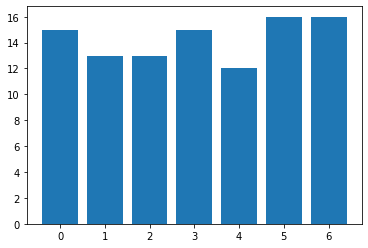

In [8]:
label_count = []
for i in range(7):
    label_count.append(np.count_nonzero(test_labels == i))

plt.bar(range(7), label_count)

In [9]:
train_data = Subset(customData, tested_indices)
test_data = Subset(CustomDataset, np.arange(800, len(customData)))
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=False, num_workers=4)
test_dataloader  = DataLoader(test_data, batch_size=4, shuffle=True, pin_memory=False, num_workers=4)


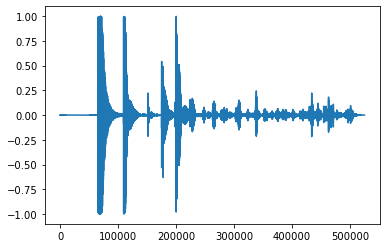

0.9982857142857143

In [10]:
normalizedarray = np.loadtxt(os.path.join("/home/marcus/Documents/munzwurf/data_normalized", "1_tisch_g16_83.csv"), delimiter =",")
plt.plot(range(len(normalizedarray)), normalizedarray)
plt.show()
max(normalizedarray)

In [11]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv1d(1, 1, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv1d(1, 1, kernel_size=3, padding=1) 
        self.conv3 = nn.Conv1d(1, 1, kernel_size=3, padding=1) 
        self.conv4 = nn.Conv1d(1, 1, kernel_size=3, padding=1) 
        self.conv5 = nn.Conv1d(1, 1, kernel_size=3, padding=1) 
      
        self.fc1   = nn.Linear(16406, 7)
     
        
        
    def forward(self, x):
        x = F.max_pool1d(F.relu(self.conv1(x)),2)
        #print(x.shape)
        x = F.max_pool1d(F.relu(self.conv2(x)),2)
        #print(x.shape)
        x = F.max_pool1d(F.relu(self.conv3(x)),2)
        #print(x.shape)
        x = F.max_pool1d(F.relu(self.conv4(x)),2)
        #print(x.shape)
        x = F.max_pool1d(F.relu(self.conv5(x)),2)
        #print(x.shape)
        x = torch.flatten(x, 1) 
        
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        """
        torch.Size([64, 1, 262500])
        torch.Size([64, 1, 131250])
        torch.Size([64, 1, 65625])
        torch.Size([64, 1, 32812])
        torch.Size([64, 1, 16406])
        """
        
        return x

In [12]:
model = Network().to(device)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

Network(
  (conv1): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(1, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=16406, out_features=7, bias=True)
)
114869


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.0001)


In [14]:
loss_array = []
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data["file"]
        labels = data["label"]
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #loss_array.append(loss.item())
        #loss_plot = plt.plot(range(len(loss_array)), loss_array)
        #plt.show()
        
        # print statistics
        running_loss += loss.item()
        print(loss)
        if i % 5 == 4:    # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0
            print(outputs, labels)

print('Finished Training')

tensor(1.9458, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9459, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9458, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9460, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9458, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9459, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9459, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.9458, device='cuda:0', grad_fn=<NllLossBackward>)


KeyboardInterrupt: 